In [2]:
import os
from google.colab import drive

import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from PIL import Image
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as model

#from aac_metrics.functional import spice
#import timm

# Configurations & Hyper-Parameters

In [3]:
ROOT_DIR = './dataset/Images/'
DATA_FILE = './dataset/captions.txt'
IMAGE_SIZE = 320
CROP_SIZE = 256
MAX_LENGTH = 25 # for captions

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

EPOCHS = 30
BATCH_SIZE = 16
LR = 1e-3
NUM_LAYERS = 3
DROPOUT_RATE = .4

ENCODER = 'efficientnet_b0'

In [4]:
!mkdir /content/dataset
#!rm -rf /content/dataset/

In [5]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/')

!unzip ./0.52k_images -d /content/dataset/Images
!unzip ./captions.txt.zip -d /content/dataset/
os.chdir('/content')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
unzip:  cannot find or open ./Images.zip, ./Images.zip.zip or ./Images.zip.ZIP.
Archive:  ./captions.txt.zip
  inflating: /content/dataset/captions.txt  


# Creating the DataFrame from the data file

In [6]:
def build_df(root_dir, data_file):
  images = list()
  captions_per_image = list()

  with open(data_file, mode='r') as f:
    lines = f.readlines()

    lines = sorted(lines[1:]) # don't include the first line (it's just a header)

    images = [root_dir + lines[i].strip().split(',', maxsplit=1)[0] for i in range(0, len(lines), 5)]
    captions_per_image = [[line.strip().split(',', maxsplit=1)[1] for line in lines[i: i+5]] for i in range(0, len(lines), 5)]

    return pd.DataFrame(
        {
            "Images" : images,
            "Captions_per_image" : captions_per_image
        }
    )

def show_image(tensor_image):
  image = np.array(tensor_image)
  image = np.transpose(image, axes=(1, 2, 0))
  plt.imshow(image)

In [ ]:
df = build_df(
    root_dir=ROOT_DIR,
    data_file=DATA_FILE
)

In [ ]:
df.head()

,Images,Captions_per_image
0,./dataset/Images/1000268201_693b08cb0e.jpg,[A child in a pink dress is climbing up a set ...
1,./dataset/Images/1001773457_577c3a7d70.jpg,"[A black dog and a spotted dog are fighting, A..."
2,./dataset/Images/1002674143_1b742ab4b8.jpg,[A little girl covered in paint sits in front ...
3,./dataset/Images/1003163366_44323f5815.jpg,[A man lays on a bench while his dog sits by h...
4,./dataset/Images/1007129816_e794419615.jpg,[A man in an orange hat starring at something ...


In [ ]:
spacy_eng = spacy.load("en_core_web_sm")

class Lang():
  def __init__(self, data_file, min_frequency):
    super(Lang, self).__init__()
    self.data_file = data_file
    self.min_frequency = min_frequency
    self.stoi = {"<sos>" : 0, "<eos>" : 1, "<pad>" : 2, "<unk>" : 3}
    self.itos = {0 : "<sos>", 1 : "<eos>", 2 : "<pad>", 3 : "<unk>"}

  def __len__(self):
    return len(self.stoi)

  def tokenize(self, input_str, max_len, sos_token="<sos>", eos_token="<eos>", pad_token="<pad>"):
    tokenized_str = [token.text.lower() for token in spacy_eng.tokenizer(input_str)]
    tokenized_str = [sos_token] + tokenized_str + [eos_token]
    if len(tokenized_str) < max_len:
      padded_len = max_len - len(tokenized_str)
      tokenized_str = tokenized_str + [pad_token] * padded_len
    if len(tokenized_str) > max_len:
      tokenized_str = tokenized_str[:max_len-2] + [eos_token] + [pad_token]
    return tokenized_str

  def get_freqs(self, text):
    freqs = dict()
    for sentence in text:
      for token in self.tokenize(sentence, max_len=MAX_LENGTH):
        if token not in freqs:
          freqs[token] = 1
        else:
          freqs[token] += 1
    return freqs

  def build_vocab(self):
    captions = list()
    with open(self.data_file, mode='r') as f:
      lines = f.readlines()
      captions = [line.strip().split(',', maxsplit=1)[1] for line in lines]

    freqs = self.get_freqs(captions)
    idx = 4
    for sentence in captions:
      for token in self.tokenize(sentence, max_len=MAX_LENGTH):
        if token not in self.stoi:
          if freqs[token] >= self.min_frequency:
            self.stoi[token] = idx
            self.itos[idx] = token
            idx += 1

  def encode(self, sentence):
    tokenized_str = self.tokenize(sentence, max_len=MAX_LENGTH)
    return [self.stoi[token] if token in self.stoi else self.stoi["<unk>"] for token in tokenized_str]

  def decode(self, encoded_str):
    return [self.itos[idx.item()] for idx in encoded_str]

In [ ]:
lang = Lang(
    data_file=DATA_FILE,
    min_frequency=2
)
lang.build_vocab()
tokenizer = lang.tokenize
encoder = lang.encode

In [ ]:
from torchvision import transforms
def transform():
  return transforms.Compose([
      transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
      transforms.CenterCrop((CROP_SIZE, CROP_SIZE)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

In [ ]:
class IC_DataSet(Dataset):
  def __init__(self, df, encoder, tokenizer, transformation):
    super(IC_DataSet, self).__init__()
    self.df = df
    self.encoder = encoder
    self.tokenizer = tokenizer
    self.transformation = transformation

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]

    image_path = row.Images
    captions = row.Captions_per_image

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = Image.fromarray(image)
    """
    if self.transformation:
      image = self.transformation(image)
      #image = np.transpose(image, axes=(2, 0, 1))
      #image = image.permute(2, 0, 1)
    """


    # image normalization and shape transposing
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = np.transpose(image, axes=(2, 0, 1))

    # randomly select one caption from the list of captions of the image
    rnd_idx = np.random.randint(0, len(captions))
    selected_caption = captions[rnd_idx]
    # tokenize & encode the selected caption
    encoded_caption = self.encoder(selected_caption)

    # converting data to tensors
    image = torch.Tensor(image) / 255.0
    encoded_caption = torch.Tensor(encoded_caption).long()

    return image, encoded_caption


In [ ]:
train_df, test_df = train_test_split(
    df,
    test_size=.2,
    random_state=42
)

In [ ]:
trainset = IC_DataSet(train_df, encoder, tokenizer, transform())
testset = IC_DataSet(test_df, encoder, tokenizer, transform())

In [ ]:
trainset[0]

(tensor([[[0.2314, 0.0745, 0.1255,  ..., 0.0824, 0.0941, 0.1255],
          [0.1804, 0.1059, 0.1216,  ..., 0.1333, 0.1137, 0.1569],
          [0.1333, 0.1176, 0.0784,  ..., 0.1882, 0.1647, 0.1137],
          ...,
          [0.0941, 0.1294, 0.0667,  ..., 0.0196, 0.0118, 0.0471],
          [0.2235, 0.1020, 0.1765,  ..., 0.3137, 0.2588, 0.1725],
          [0.1176, 0.2196, 0.1686,  ..., 0.1686, 0.2549, 0.3451]],
 
         [[0.2392, 0.0824, 0.1373,  ..., 0.0667, 0.0784, 0.0980],
          [0.2000, 0.1569, 0.1765,  ..., 0.1098, 0.0941, 0.1176],
          [0.2078, 0.1804, 0.1255,  ..., 0.1373, 0.1333, 0.0941],
          ...,
          [0.0863, 0.0784, 0.0471,  ..., 0.0235, 0.0078, 0.0471],
          [0.1608, 0.0392, 0.0784,  ..., 0.2588, 0.2078, 0.1216],
          [0.0784, 0.1176, 0.1216,  ..., 0.1294, 0.1843, 0.2196]],
 
         [[0.1686, 0.0706, 0.1255,  ..., 0.0824, 0.0627, 0.0627],
          [0.1294, 0.0549, 0.1059,  ..., 0.0863, 0.0627, 0.0863],
          [0.0941, 0.0784, 0.0471,  ...,

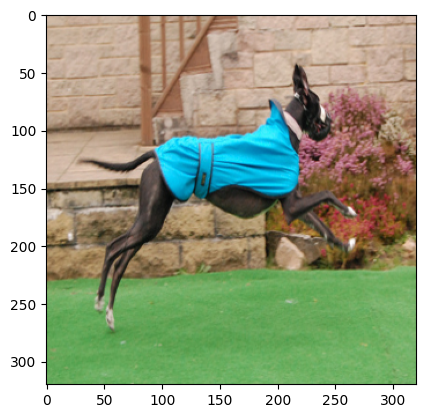

In [ ]:
show_image(trainset[3][0])

In [ ]:
trainloader = DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

testloader = DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [ ]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in testloader : {len(testloader)}")

total no. of batches in trainloader : 405
total no. of batches in testloader : 102


In [ ]:
for images, captions in trainloader:
  break
print(f"One batch image shape : {images.shape}")
print(f"One batch caption shape : {captions.shape}")
captions.shape

One batch image shape : torch.Size([16, 3, 320, 320])
One batch caption shape : torch.Size([16, 25])


torch.Size([16, 25])

#***Creating the Image Captioning Model***

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.6 MB/s eta 0:00:00


In [ ]:
FEATURES_SIZE = 1280 # Efficientnet-bO
FEATURES_SIZE_ = 25088 # VGG16
EMBEDDING_SIZE = 512
HIDDEN_SIZE = 512
VOCAB_SIZE = len(lang.itos)
print(VOCAB_SIZE)

5159


In [ ]:
# meth 2
"""
class CNN_Encoder(nn.Module):

  def __init__(self, model_name, pretrained=True, embedding_size=EMBEDDING_SIZE):
    super(CNN_Encoder, self).__init__()
    vgg16 = model.vgg16(pretrained=pretrained)

    for param in vgg16.parameters():
      param.requires_grad_(False)

    self.vgg16 = nn.Sequential(*list(self.vgg16.children())[:-1])
    self.ln = nn.Linear(
        in_features=FEATURES_SIZE_,
        out_features=HIDDEN_SIZE
    )

  def forward(self, images):
    features = self.vgg16(images)
    features = features.view(features.size(0), -1)
    features = self.ln(features)
    return features
"""

'\nclass CNN_Encoder(nn.Module):\n\n  def __init__(self, model_name, pretrained=True, embedding_size=EMBEDDING_SIZE):\n    super(CNN_Encoder, self).__init__()\n    vgg16 = model.vgg16(pretrained=pretrained)\n\n    for param in vgg16.parameters():\n      param.requires_grad_(False)\n\n    self.vgg16 = nn.Sequential(*list(self.vgg16.children())[:-1])\n    self.ln = nn.Linear(\n        in_features=FEATURES_SIZE_,\n        out_features=HIDDEN_SIZE\n    )\n\n  def forward(self, images):\n    features = self.vgg16(images)\n    features = features.view(features.size(0), -1)\n    features = self.ln(features)\n    return features\n'

In [ ]:

class CNN_Encoder(nn.Module):

  def __init__(self, model_name, pretrained=True, embedding_size=EMBEDDING_SIZE):
    super(CNN_Encoder, self).__init__()
    self.cnn = timm.create_model(
        model_name=model_name,
        pretrained=pretrained
    )
    self.features = nn.Sequential(*list(self.cnn.children())[:-1])
    self.ln = nn.Linear(
        in_features=FEATURES_SIZE,
        out_features=HIDDEN_SIZE
    )

    for param in self.features.parameters():
      param.requires_grad = False


  def forward(self, images):
    features = self.features(images)
    features = self.ln(features)
    return features


In [ ]:
import timm
avail_pretrained_models = timm.list_models(pretrained=True)
print(f"there's {len(avail_pretrained_models)} pretrained models available")

there's 1260 pretrained models available


In [ ]:
"""
a = 0
for image, caption in trainloader:
  a = cnn_encoder(image.to(DEVICE))
  break
print(a.shape)
print(a[0].shape)
print(a[0]) # features vector of the first image in the first batch
"""

'\na = 0\nfor image, caption in trainloader:\n  a = cnn_encoder(image.to(DEVICE))\n  break\nprint(a.shape)\nprint(a[0].shape)\nprint(a[0]) # features vector of the first image in the first batch\n'

In [ ]:
class LSTM_decoder(nn.Module):

  def __init__(self, vocab_size, embedding_size, hidden_size, num_layers=3, dropout_rate=.6, teacher_forcing_ratio=.5):
    super(LSTM_decoder, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.teacher_forcing_ratio = teacher_forcing_ratio

    self.embedding = nn.Embedding(
        num_embeddings=vocab_size,
        embedding_dim=embedding_size
    )

    self.dropout = nn.Dropout(
        p=dropout_rate
    )

    self.lstm = nn.LSTM(
        input_size=embedding_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True
    )
    self.lr = nn.Linear(
        in_features=hidden_size,
        out_features=vocab_size
    )
    #self.softm = nn.Softmax(dim=2)

  def forward(self, features, captions):
    shapes = {}
    # features shape : (batch_size, hidden_size) so in order to pass it as hidden state the shape shoud be --> (num_layers, batch_size, hidden_size)
    batch_size = captions.size(0)
    #initial_hidden = features.view(self.num_layers, batch_size, self.hidden_size)
    #initial_cell = features.view(self.num_layers, batch_size, self.hidden_size)

    # Reshape features to initialize LSTM states
    initial_hidden = features.unsqueeze(0).repeat(self.num_layers, 1, 1)
    initial_cell = features.unsqueeze(0).repeat(self.num_layers, 1, 1)


    # initializing the input tokens to the lstm with the sos_token '<sos>'
    in_tokens = captions[:, 0].unsqueeze(dim=1)
    shapes["in_token"] = in_tokens.shape

    max_length = captions.size(1)
    preds = []
    #preds.append(in_tokens)
    for t in range(1, max_length):
      embedded = self.embedding(in_tokens) # Embedd the input tokens
      shapes["embedding"] = embedded.shape
      # Apply dropout after the embedding layer
      embedded = self.dropout(embedded)

      output, _ = self.lstm(embedded.view(batch_size, 1, -1), (initial_hidden, initial_cell)) # Pass the embeddings to the lstm
      shapes["lstm_out"] = output.shape
      output = self.lr(output) # Pass the lstm output to the linear layer (this is to map the hidden_size to the vocab_size)
      shapes["linear_out"] = output.shape
      output = F.softmax(output, dim=-1) # Apply a softmax activation function on the output (distribution of word probabilities)
      shapes["softmax_out"] = output.shape
      #pred_idxs = torch.argmax(output, dim=-1)# Get the index with the high probability
      #shapes["pred_idxs"] = pred_idxs.shape
      preds.append(output)
      # Apply teacher forcing
      #if self.training:
      #use_tf = (self.teacher_forcing_ratio > torch.rand(1).item())
      #shapes["use_tf"] = use_tf
      #if use_tf:
      in_tokens = captions[:, t]
      #  shapes["use_tf_true"] = in_tokens.shape
      #else:
        #in_tokens = torch.argmax(output, dim=-1).view(batch_size, 1)

    #preds = torch.stack(preds).transpose(-1, 0)

    preds_ = torch.cat(preds, dim=1)

    return preds_, shapes

In [ ]:
class IC_Model(nn.Module):

  def __init__(self, encoder, decoder):
    super(IC_Model, self).__init__()
    self.cnn_encoder = encoder
    self.lstm_decoder = decoder

  def forward(self, images, captions):
    features = self.cnn_encoder(images)
    outputs, _ = self.lstm_decoder(features, captions)
    return outputs

In [ ]:
cnn_encoder = CNN_Encoder(
    model_name=ENCODER
)
cnn_encoder.to(DEVICE)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

CNN_Encoder(
  (cnn): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1)

In [ ]:
for images, captions in trainloader:
  break
features = cnn_encoder(images.to(DEVICE))
captions = captions.to(DEVICE)

In [ ]:
features.shape

torch.Size([16, 512])

In [ ]:
lstm_decoder = LSTM_decoder(
    vocab_size=VOCAB_SIZE,
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
)
lstm_decoder.to(DEVICE)

LSTM_decoder(
  (embedding): Embedding(5159, 512)
  (dropout): Dropout(p=0.6, inplace=False)
  (lstm): LSTM(512, 512, num_layers=3, batch_first=True)
  (lr): Linear(in_features=512, out_features=5159, bias=True)
)

In [ ]:
#output, shapes = lstm_decoder(features, captions)

In [ ]:
#output.shape

In [ ]:
#output

In [ ]:
#shapes

In [ ]:
model = IC_Model(
    encoder=cnn_encoder,
    decoder=lstm_decoder
)
model.to(DEVICE)

IC_Model(
  (cnn_encoder): CNN_Encoder(
    (cnn): EfficientNet(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid

# Train Model

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=lang.stoi['<pad>']).cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss(ignore_index=lang.stoi['<pad>'])
def train_fn(dataloader, model, criterion, optimizer):

  model.train()
  total_loss = 0.0

  for images, captions in tqdm(dataloader):
    images = images.to(DEVICE)
    captions = captions.to(DEVICE)
    optimizer.zero_grad()
    outputs = model(images, captions)
    #print(outputs.shape)
    #print(captions[:, 1:].reshape(-1).shape)
    batch_size, seq_len, vocab_size = outputs.size()
    loss = criterion(outputs.view(batch_size * seq_len, vocab_size), captions[:, 1:].reshape(-1))
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
input.shape, target

(torch.Size([3, 5]), tensor([1, 0, 3]))

In [ ]:
def eval_fn(dataloader, model, criterion):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, captions in tqdm(dataloader):
      images = images.to(DEVICE)
      captions = captions.to(DEVICE)

      outputs = model(images, captions)
      batch_size, seq_len, vocab_size = outputs.size()
      loss = criterion(outputs.view(batch_size * seq_len, vocab_size), captions[:, 1:].reshape(-1))
      total_loss += loss.item()
  return total_loss / len(dataloader)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
# version 2
best_test_loss = np.Inf
#model.load_state_dict(torch.load('/content/best_model_pt'))
for epoch in range(EPOCHS):
  train_loss = train_fn(dataloader=trainloader, model=model, criterion=criterion, optimizer=optimizer)
  #test_loss = eval_fn(dataloader=testloader, criterion=criterion, model=model)

  torch.save(model.state_dict(), 'best_model_pt')
  print("MODEL SAVED")
  best_test_loss = train_loss

  print(f"Epoch : {epoch+1}   Train_loss : {train_loss}")

100%|██████████| 405/405 [01:21<00:00,  4.97it/s]


MODEL SAVED
Epoch : 1   Train_loss : 8.431218083699545


100%|██████████| 405/405 [01:18<00:00,  5.13it/s]


MODEL SAVED
Epoch : 2   Train_loss : 8.429013732627586


100%|██████████| 405/405 [01:27<00:00,  4.63it/s]


MODEL SAVED
Epoch : 3   Train_loss : 8.379884079356252


100%|██████████| 405/405 [01:21<00:00,  4.97it/s]


MODEL SAVED
Epoch : 4   Train_loss : 8.36143561233709


100%|██████████| 405/405 [01:18<00:00,  5.15it/s]


MODEL SAVED
Epoch : 5   Train_loss : 8.36111003028022


100%|██████████| 405/405 [01:19<00:00,  5.10it/s]


MODEL SAVED
Epoch : 6   Train_loss : 8.329923474347149


100%|██████████| 405/405 [01:18<00:00,  5.13it/s]


MODEL SAVED
Epoch : 7   Train_loss : 8.3086664011449


100%|██████████| 405/405 [01:18<00:00,  5.18it/s]


MODEL SAVED
Epoch : 8   Train_loss : 8.305658632443276


100%|██████████| 405/405 [01:18<00:00,  5.18it/s]


MODEL SAVED
Epoch : 9   Train_loss : 8.305234937314633


100%|██████████| 405/405 [01:18<00:00,  5.16it/s]


MODEL SAVED
Epoch : 10   Train_loss : 8.303376101270134


100%|██████████| 405/405 [01:18<00:00,  5.16it/s]


MODEL SAVED
Epoch : 11   Train_loss : 8.303786776978292


100%|██████████| 405/405 [01:18<00:00,  5.18it/s]


MODEL SAVED
Epoch : 12   Train_loss : 8.301574309078264


100%|██████████| 405/405 [01:18<00:00,  5.19it/s]


MODEL SAVED
Epoch : 13   Train_loss : 8.302389043643151


100%|██████████| 405/405 [01:18<00:00,  5.18it/s]


MODEL SAVED
Epoch : 14   Train_loss : 8.30054852520978


100%|██████████| 405/405 [01:18<00:00,  5.19it/s]


MODEL SAVED
Epoch : 15   Train_loss : 8.30115193967466


100%|██████████| 405/405 [01:18<00:00,  5.18it/s]


MODEL SAVED
Epoch : 16   Train_loss : 8.302584916573984


100%|██████████| 405/405 [01:17<00:00,  5.22it/s]


MODEL SAVED
Epoch : 17   Train_loss : 8.300520392994821


100%|██████████| 405/405 [01:18<00:00,  5.19it/s]


MODEL SAVED
Epoch : 18   Train_loss : 8.301840655008952


100%|██████████| 405/405 [01:18<00:00,  5.19it/s]


MODEL SAVED
Epoch : 19   Train_loss : 8.300956313992724


100%|██████████| 405/405 [01:17<00:00,  5.21it/s]


MODEL SAVED
Epoch : 20   Train_loss : 8.300800959269205


100%|██████████| 405/405 [01:17<00:00,  5.22it/s]


MODEL SAVED
Epoch : 21   Train_loss : 8.299686886351786


100%|██████████| 405/405 [01:17<00:00,  5.21it/s]


MODEL SAVED
Epoch : 22   Train_loss : 8.299674797058106


100%|██████████| 405/405 [01:17<00:00,  5.20it/s]


MODEL SAVED
Epoch : 23   Train_loss : 8.299200882146389


100%|██████████| 405/405 [01:18<00:00,  5.16it/s]


MODEL SAVED
Epoch : 24   Train_loss : 8.299211419658896


100%|██████████| 405/405 [01:18<00:00,  5.17it/s]


MODEL SAVED
Epoch : 25   Train_loss : 8.300983299443752


100%|██████████| 405/405 [01:18<00:00,  5.18it/s]


MODEL SAVED
Epoch : 26   Train_loss : 8.299675701282643


100%|██████████| 405/405 [01:18<00:00,  5.18it/s]


MODEL SAVED
Epoch : 27   Train_loss : 8.299936092047044


100%|██████████| 405/405 [01:17<00:00,  5.19it/s]


MODEL SAVED
Epoch : 28   Train_loss : 8.298777794543607


100%|██████████| 405/405 [01:18<00:00,  5.18it/s]


MODEL SAVED
Epoch : 29   Train_loss : 8.297818433502574


100%|██████████| 405/405 [01:18<00:00,  5.17it/s]


MODEL SAVED
Epoch : 30   Train_loss : 8.298469585842556


In [ ]:
best_test_loss = np.Inf
#model.load_state_dict(torch.load('/content/best_model_pt'))
for epoch in range(EPOCHS):
  train_loss = train_fn(dataloader=trainloader, model=model, criterion=criterion, optimizer=optimizer)
  test_loss = eval_fn(dataloader=testloader, criterion=criterion, model=model)

  if test_loss  < train_loss:
    torch.save(model.state_dict(), 'best_model_pt')
    print("MODEL SAVED")
    best_test_loss = test_loss

  print(f"Epoch : {epoch+1}   Train_loss : {train_loss}   Valid_loss : {test_loss}")

100%|██████████| 102/102 [00:16<00:00,  6.12it/s]


MODEL SAVED
Epoch : 1   Train_loss : 8.424880762453432   Valid_loss : 8.363981751834645


100%|██████████| 102/102 [00:15<00:00,  6.66it/s]


MODEL SAVED
Epoch : 2   Train_loss : 8.363935661315917   Valid_loss : 8.3630298352709


100%|██████████| 102/102 [00:15<00:00,  6.75it/s]


MODEL SAVED
Epoch : 3   Train_loss : 8.362925760245618   Valid_loss : 8.361625063653086


100%|██████████| 102/102 [00:15<00:00,  6.77it/s]


MODEL SAVED
Epoch : 4   Train_loss : 8.363696519828137   Valid_loss : 8.360501551160626


100%|██████████| 102/102 [00:15<00:00,  6.78it/s]


MODEL SAVED
Epoch : 5   Train_loss : 8.363251900378568   Valid_loss : 8.36243569617178


100%|██████████| 102/102 [00:15<00:00,  6.50it/s]


MODEL SAVED
Epoch : 6   Train_loss : 8.363796210583345   Valid_loss : 8.362008852117201


100%|██████████| 102/102 [00:15<00:00,  6.75it/s]


MODEL SAVED
Epoch : 7   Train_loss : 8.364804750607338   Valid_loss : 8.36159647212309


100%|██████████| 102/102 [00:15<00:00,  6.70it/s]


MODEL SAVED
Epoch : 8   Train_loss : 8.363329416439857   Valid_loss : 8.360317996903962


100%|██████████| 102/102 [00:15<00:00,  6.76it/s]


MODEL SAVED
Epoch : 9   Train_loss : 8.362931091402784   Valid_loss : 8.361512034547095


100%|██████████| 102/102 [00:16<00:00,  6.24it/s]


MODEL SAVED
Epoch : 10   Train_loss : 8.363875238395032   Valid_loss : 8.358711130478802


100%|██████████| 102/102 [00:15<00:00,  6.76it/s]


MODEL SAVED
Epoch : 11   Train_loss : 8.36219169004464   Valid_loss : 8.359330906587488


100%|██████████| 102/102 [00:15<00:00,  6.62it/s]


Epoch : 12   Train_loss : 8.36257053186864   Valid_loss : 8.362854134802724


100%|██████████| 102/102 [00:15<00:00,  6.66it/s]


MODEL SAVED
Epoch : 13   Train_loss : 8.365073262909313   Valid_loss : 8.358134998994714


100%|██████████| 102/102 [00:15<00:00,  6.60it/s]


MODEL SAVED
Epoch : 14   Train_loss : 8.363027737464433   Valid_loss : 8.357794658810485


100%|██████████| 102/102 [00:15<00:00,  6.66it/s]


MODEL SAVED
Epoch : 15   Train_loss : 8.363716302094636   Valid_loss : 8.362048523098816


100%|██████████| 102/102 [00:15<00:00,  6.64it/s]


MODEL SAVED
Epoch : 16   Train_loss : 8.364185194321621   Valid_loss : 8.361519729389864


100%|██████████| 102/102 [00:15<00:00,  6.43it/s]


MODEL SAVED
Epoch : 17   Train_loss : 8.364270368034457   Valid_loss : 8.361332005145503


100%|██████████| 102/102 [00:15<00:00,  6.62it/s]


MODEL SAVED
Epoch : 18   Train_loss : 8.32849442517316   Valid_loss : 8.303453005996404


100%|██████████| 102/102 [00:15<00:00,  6.62it/s]


MODEL SAVED
Epoch : 19   Train_loss : 8.304663375571922   Valid_loss : 8.298406161513983


100%|██████████| 102/102 [00:15<00:00,  6.40it/s]


MODEL SAVED
Epoch : 20   Train_loss : 8.302583645008228   Valid_loss : 8.295301914215088


100%|██████████| 102/102 [00:15<00:00,  6.67it/s]


MODEL SAVED
Epoch : 21   Train_loss : 8.30067238042384   Valid_loss : 8.296582408979827


100%|██████████| 102/102 [00:15<00:00,  6.63it/s]


MODEL SAVED
Epoch : 22   Train_loss : 8.300796308635194   Valid_loss : 8.29642313601924


100%|██████████| 102/102 [00:15<00:00,  6.44it/s]


MODEL SAVED
Epoch : 23   Train_loss : 8.301747917834623   Valid_loss : 8.298017754274255


100%|██████████| 102/102 [00:15<00:00,  6.44it/s]


MODEL SAVED
Epoch : 24   Train_loss : 8.301623589315533   Valid_loss : 8.29927282707364


100%|██████████| 102/102 [00:15<00:00,  6.66it/s]


MODEL SAVED
Epoch : 25   Train_loss : 8.2988789735017   Valid_loss : 8.296892427930645


100%|██████████| 102/102 [00:15<00:00,  6.52it/s]


MODEL SAVED
Epoch : 26   Train_loss : 8.300281786035608   Valid_loss : 8.299914322647394


100%|██████████| 102/102 [00:15<00:00,  6.48it/s]


MODEL SAVED
Epoch : 27   Train_loss : 8.29188343566141   Valid_loss : 8.287341678843779


100%|██████████| 102/102 [00:15<00:00,  6.57it/s]


MODEL SAVED
Epoch : 28   Train_loss : 8.288661766052247   Valid_loss : 8.28604653302361


100%|██████████| 102/102 [00:15<00:00,  6.62it/s]


MODEL SAVED
Epoch : 29   Train_loss : 8.28902783334991   Valid_loss : 8.286020475275377


100%|██████████| 102/102 [00:15<00:00,  6.50it/s]


MODEL SAVED
Epoch : 30   Train_loss : 8.288331938378604   Valid_loss : 8.285309913111668


In [ ]:
# After training once :  [00:00<00:00,  7.88it/s]Epoch : 20   Train_loss : 6.8618403031275825   Valid_loss : 6.861988476344517
# After training twice:

# Inference

In [ ]:
model.load_state_dict(torch.load('/content/best_model_pt'))

<All keys matched successfully>

In [ ]:
idx = 30
image, caption = testset[idx]

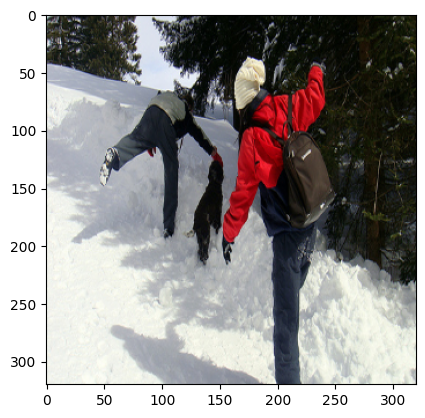

In [ ]:
show_image(image)

In [ ]:
caption

tensor([  0,  50, 200,  31,   4,  30,  33,   6,  25, 180,  17,   1,   2,   2,
          2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2])

In [ ]:
lang.decode(caption)

['<sos>',
 'two',
 'people',
 'and',
 'a',
 'dog',
 'are',
 'in',
 'the',
 'snow',
 '.',
 '<eos>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [ ]:
out = model(image.to(DEVICE).unsqueeze(0), caption.to(DEVICE).unsqueeze(0))

In [ ]:
out.shape

torch.Size([1, 24, 5159])

In [ ]:
out

tensor([[[9.6411e-14, 1.0063e-11, 4.5054e-14,  ..., 7.2441e-14,
          8.4685e-14, 1.1910e-13],
         [2.7769e-10, 9.3341e-08, 1.5547e-10,  ..., 2.9239e-10,
          2.4362e-10, 3.7051e-10],
         [7.9446e-10, 6.5582e-07, 5.5121e-10,  ..., 7.5217e-10,
          6.1991e-10, 8.2532e-10],
         ...,
         [3.1392e-13, 3.4674e-11, 1.4525e-13,  ..., 2.8027e-13,
          2.7330e-13, 4.1162e-13],
         [1.2341e-12, 1.0528e-10, 5.8954e-13,  ..., 1.1465e-12,
          1.0792e-12, 1.6159e-12],
         [1.0275e-12, 8.9616e-11, 4.8704e-13,  ..., 9.4355e-13,
          8.9494e-13, 1.3421e-12]]], device='cuda:0', grad_fn=<CatBackward0>)

In [ ]:
preds = torch.argmax(out, dim=-1)

In [ ]:
preds.shape

torch.Size([1, 24])

In [ ]:
preds

tensor([[ 4,  4, 17,  4,  4, 17, 17,  4,  4, 17,  1,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4]], device='cuda:0')

In [ ]:
lang.decode(preds[0])

['a',
 'a',
 '.',
 'a',
 'a',
 '.',
 '.',
 'a',
 'a',
 '.',
 '<eos>',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a']